# Libraries

In [8]:
import pickle
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from pep_modules import patientai as pai

In [2]:
def plot_roc_curve(y_true, y_score, roc_auc_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=(10,7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Loading data

In [26]:
cross_df = pd.read_pickle(r'../data/cross_data.pkl')
targets_df = pd.read_pickle(r'../data/target.pkl')

x_train_static = pd.read_pickle(r'../data/train_static.pkl')
x_val_static = pd.read_pickle(r'../data/val_static.pkl')
x_test_static = pd.read_pickle(r'../data/test_static.pkl')

In [4]:
print(cross_df.shape)
cross_df.head()

(45980, 4)


,pat_id,journey,event_day,marked_journey
0,2,"[NEO*IV*Gentamicin, Syringe (Neonatal) *D5W*, ...","[1, 2, 3, 4, 5, 6, 7, 8]","[NEO*IV*Gentamicin, Syringe (Neonatal) *D5W*, ..."
1,3,"[966.0, 3893.0, 9672.0, 8964.0, 9962.0, 9604.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[966.0, 3893.0, 9672.0, 8964.0, 9962.0, 9604.0..."
2,4,"[D5W, Vancomycin HCl, Potassium Chloride, Insu...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[D5W, Vancomycin HCl, Potassium Chloride, Insu..."
3,5,"[9955.0, V290, V053, V3000]","[1, 2, 3, 4]","[9955.0, V290, V053, V3000]"
4,6,"[Tacrolimus, Tacrolimus, Valganciclovir HCl, W...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[Tacrolimus, Tacrolimus, Valganciclovir HCl, W..."


In [6]:
# CLass imbalance
targets_df.switch_flag.sum()*100/len(targets_df)

3.357981731187473

In [29]:
X1, X_test, y1, y_test = train_test_split(cross_df, targets_df, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.15, random_state=42)

# Best Results

In [27]:
# best parameters without and with static features
w2v_dim_static = 32
jlen_static = 85
window_size_static = 5

w2v_dim = 128
jlen = 120
window_size = 6

## Without static 

In [28]:
loaded_word2vec = Word2Vec.load(f'../saved_models/word2vec_{w2v_dim}.model')

In [33]:
x_train_tensor, y_train_tensor = pai.get_all_tensors_deepr(X_train,'journey',
                                                                 y_train,'switch_flag',loaded_word2vec,jlen)
x_val_tensor, y_val_tensor = pai.get_all_tensors_deepr(X_val,'journey',
                                                             y_val,'switch_flag',loaded_word2vec,jlen)
x_test_tensor, y_test_tensor = pai.get_all_tensors_deepr(X_test,'journey',
                                                               y_test,'switch_flag',loaded_word2vec,jlen)

print(x_train_tensor.shape, x_val_tensor.shape, x_test_tensor.shape)

(31266, 128, 120, 1) (5518, 128, 120, 1) (9196, 128, 120, 1)


In [34]:
model = pai.build_model_deepr(input_shape=(w2v_dim,jlen,1), kernel_size=(w2v_dim,window_size), show_summary=False)
model.load_weights(f'../saved_models/deepr_tuning/deepr_w2v{w2v_dim}_jlen{jlen}_win{window_size}')

In [35]:
trn_result = model.evaluate(x_train_tensor,y_train_tensor)

31266/31266 [==============================] - 7s 219us/sample - loss: 0.1271 - my_auc: 0.7852


In [39]:
val_results = model.evaluate(x_val_tensor,y_val_tensor)

5518/5518 [==============================] - 1s 175us/sample - loss: 0.1568 - my_auc: 0.6514


In [40]:
test_results = model.evaluate(x_test_tensor,y_test_tensor)
y_test_pred = model.predict(x_test_tensor)

9196/9196 [==============================] - 2s 176us/sample - loss: 0.1457 - my_auc: 0.6769


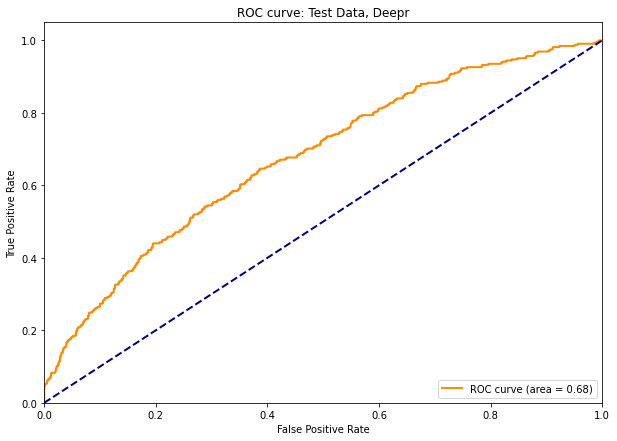

In [41]:
plot_roc_curve(y_test_tensor, y_test_pred, test_results[1], 'ROC curve: Test Data, Deepr')

# Static Features

In [42]:
loaded_word2vec = Word2Vec.load(f'../saved_models/word2vec_{w2v_dim_static}.model')

In [43]:
x_train_tensor, y_train_tensor = pai.get_all_tensors_deepr(X_train,'journey',
                                                                 y_train,'switch_flag',loaded_word2vec,jlen_static)
x_val_tensor, y_val_tensor = pai.get_all_tensors_deepr(X_val,'journey',
                                                             y_val,'switch_flag',loaded_word2vec,jlen_static)
x_test_tensor, y_test_tensor = pai.get_all_tensors_deepr(X_test,'journey',
                                                               y_test,'switch_flag',loaded_word2vec,jlen_static)

print(x_train_tensor.shape, x_val_tensor.shape, x_test_tensor.shape)

(31266, 32, 85, 1) (5518, 32, 85, 1) (9196, 32, 85, 1)


In [44]:
model = pai.build_model_deepr(input_shape=(w2v_dim_static,jlen_static,1), kernel_size=(w2v_dim_static,window_size_static), n_static=182, show_summary=False)
model.load_weights(f'../saved_models/deepr_tuning/static_deepr_w2v{w2v_dim_static}_jlen{jlen_static}_win{window_size_static}')

In [46]:
trn_result = model.evaluate([x_train_tensor,x_train_static],y_train_tensor)

31266/31266 [==============================] - 5s 150us/sample - loss: 0.0892 - my_auc: 0.9297


In [47]:
val_results = model.evaluate([x_val_tensor, x_val_static],y_val_tensor)

5518/5518 [==============================] - 1s 126us/sample - loss: 0.1593 - my_auc: 0.7230


In [50]:
test_results = model.evaluate([x_test_tensor,x_test_static],y_test_tensor)
y_test_pred = model.predict([x_test_tensor,x_test_static])

9196/9196 [==============================] - 1s 147us/sample - loss: 0.1461 - my_auc: 0.7405


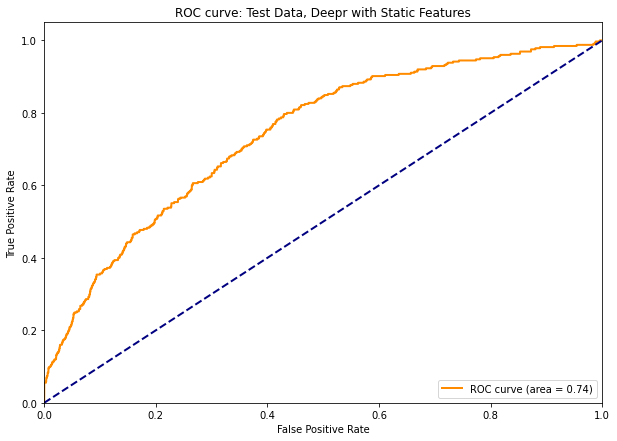

In [53]:
plot_roc_curve(y_test_tensor, y_test_pred, test_results[1], 'ROC curve: Test Data, Deepr with Static Features')